In [ ]:
import os, json, random, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, confusion_matrix, precision_score, recall_score,
                             f1_score, roc_auc_score, average_precision_score, precision_recall_curve)
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests
import joblib

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

print('Libraries imported.')

Libraries imported.


In [ ]:
DATA_PATH = 'creditcard.csv'  

df = pd.read_csv(DATA_PATH, low_memory=False)
display(df.head())
print('Shape:', df.shape)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Shape: (284807, 31)


expected 284,807 rows and 31 columns (Time, V1..V28, Amount, Class). Head preview validates structure.

In [ ]:
# Quick overview 
if 'df' in globals():
    display(df.info())
    display(df.describe().T.head())
    print('Dtypes summary:')
    print(df.dtypes.value_counts())
    print('\nClass distribution:\n', df['Class'].value_counts())
else:
    print('DataFrame df not loaded yet.')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

None

,count,mean,std,min,25%,50%,75%,max
Time,284807.0,9.481386e+04,47488.145955,0.000000,54201.500000,84692.000000,139320.500000,172792.000000
V1,284807.0,1.168375e-15,1.958696,-56.407510,-0.920373,0.018109,1.315642,2.454930
V2,284807.0,3.416908e-16,1.651309,-72.715728,-0.598550,0.065486,0.803724,22.057729
V3,284807.0,-1.379537e-15,1.516255,-48.325589,-0.890365,0.179846,1.027196,9.382558
V4,284807.0,2.074095e-15,1.415869,-5.683171,-0.848640,-0.019847,0.743341,16.875344


Dtypes summary:
float64    30
int64       1
Name: count, dtype: int64

Class distribution:
 Class
0    284315
1       492
Name: count, dtype: int64


Class imbalance visible with fraud minority count.

## Section 4: Missing Values & Data Quality Checks

In [ ]:
# Data quality checks
missing = df.isna().sum()
print('Missing values (top 10):')
print(missing[missing>0].sort_values(ascending=False).head(10))
dup_count = df.duplicated().sum()
print(f'\nDuplicate rows: {dup_count}')
nunique = df.nunique()
constant_cols = nunique[nunique==1].index.tolist()
print(f'Constant columns: {constant_cols if constant_cols else "None"}')

Missing values (top 10):
Series([], dtype: int64)

Duplicate rows: 1081

Duplicate rows: 1081
Constant columns: None
Constant columns: None


no missing values and no duplicates so gooddddd
and duplicate rows count is very less, i think we can leave it as it is as it might be showing inter-relation and importance of those values

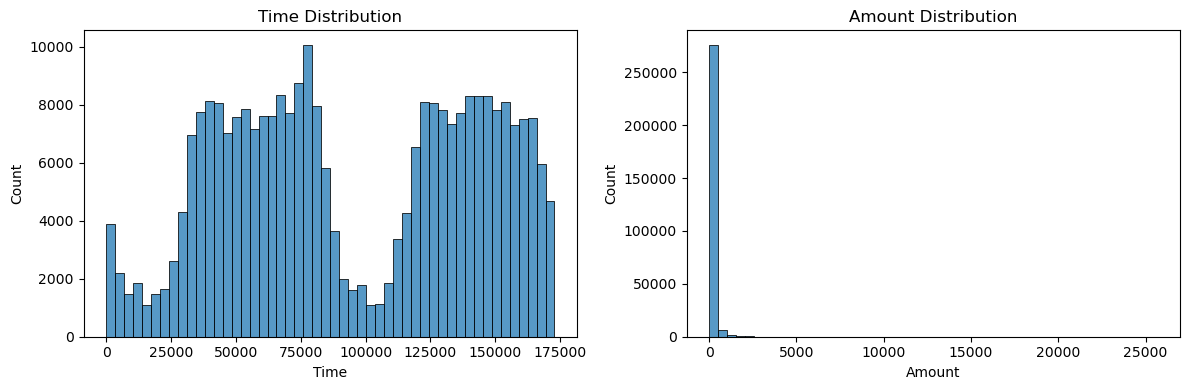

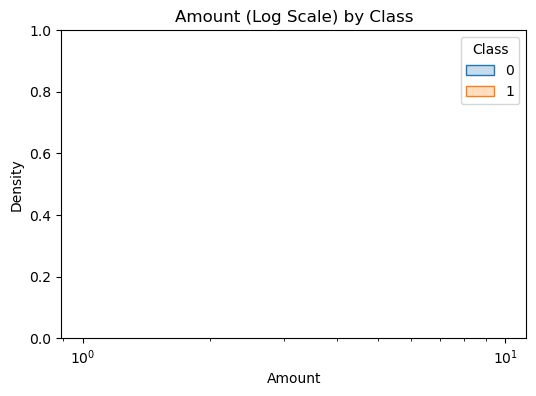

In [ ]:
# distributions for Time and Amount, and overlay fraud vs non-fraud for Amount
fig, axes = plt.subplots(1, 2, figsize=(12,4))
sns.histplot(df['Time'], bins=50, ax=axes[0], kde=False)
axes[0].set_title('Time Distribution')
sns.histplot(df['Amount'], bins=50, ax=axes[1], kde=False)
axes[1].set_title('Amount Distribution')
plt.tight_layout()
plt.show()

# Fraud vs non-fraud Amount (log scale)
plt.figure(figsize=(6,4))
sns.kdeplot(data=df, x='Amount', hue='Class', common_norm=False, fill=True, log_scale=True)
plt.title('Amount (Log Scale) by Class')
plt.show()

Amount is right-skewed; log scale clarifies separation. Fraud transactions cluster in specific amount ranges. 

Time shows periodic pattern.

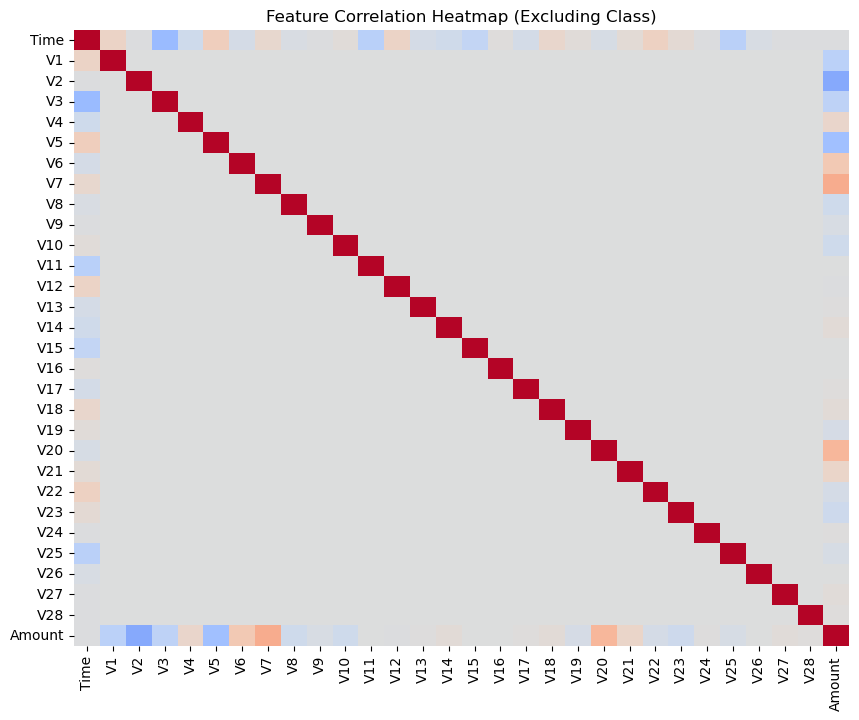

In [ ]:
corr = df.drop(columns=['Class']).corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, cmap='coolwarm', center=0, cbar=False)
plt.title('Feature Correlation Heatmap (Excluding Class)')
plt.show()


PCA-like transformed features (V) are mostly decorrelated

i don't see any multi-colinearity risk

so ek vaar try linear or logistic regression also

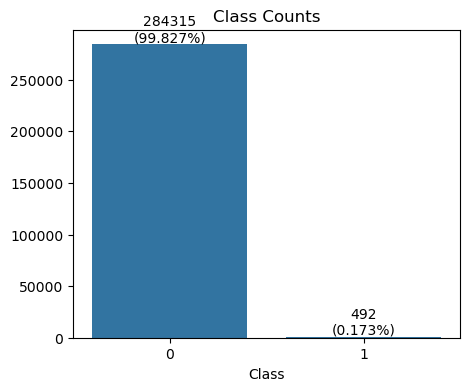

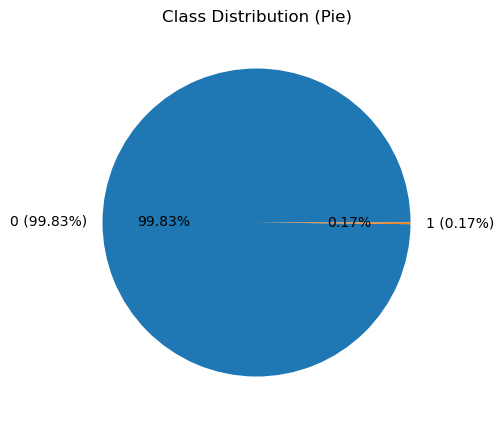

In [8]:
# Class distribution plots
if 'df' in globals():
    class_counts = df['Class'].value_counts()
    plt.figure(figsize=(5,4))
    sns.barplot(x=class_counts.index, y=class_counts.values)
    plt.title('Class Counts')
    for i,v in enumerate(class_counts.values):
        plt.text(i, v, f'{v}\n({v/class_counts.sum():.3%})', ha='center', va='bottom')
    plt.show()

    plt.figure(figsize=(5,5))
    plt.pie(class_counts.values, labels=[f'{c} ({class_counts[c]/class_counts.sum():.2%})' for c in class_counts.index], autopct='%1.2f%%')
    plt.title('Class Distribution (Pie)')
    plt.show()
else:
    print('DataFrame df not loaded.')

Fraudulent class (~0.17%) is extremely rare, underscoring need for recall-focused metrics and sampling strategies.

## just an observation from EDA je nikde che is
Models trained naively optimize overall accuracy—predicting all transactions as non-fraud yields >99% accuracy but 0 recall for fraud. This leads to high financial risk. Precision-Recall (especially PR-AUC) becomes more informative than ROC-AUC when positives are rare. Threshold tuning, cost-sensitive learning, and sampling are required.

In [ ]:
# Stratified split
X = df.drop(columns=['Class'])
y = df['Class']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE)
print('Train shape:', X_train.shape, 'Test shape:', X_test.shape)
print('Train class distribution:\n', y_train.value_counts())

Train shape: (227845, 30) Test shape: (56962, 30)
Train class distribution:
 Class
0    227451
1       394
Name: count, dtype: int64


Stratification preserves rare class proportion in both train and test, ensuring evaluation validity as subgroups bane and pachi ene equally divide kare randomly

In [ ]:
# no sampling par basic model evaluation
def train_and_eval(model, X_tr, y_tr, X_te, y_te, label):
    model.fit(X_tr, y_tr)
    preds = model.predict(X_te)
    proba = model.predict_proba(X_te)[:,1]
    metrics = {
        'model': label,
        'precision': precision_score(y_te, preds, zero_division=0),
        'recall': recall_score(y_te, preds, zero_division=0),
        'f1': f1_score(y_te, preds, zero_division=0),
        'roc_auc': roc_auc_score(y_te, proba),
        'pr_auc': average_precision_score(y_te, proba)
    }
    return metrics, preds, proba

baseline_results = []
log_reg = LogisticRegression(max_iter=1000, n_jobs=None, random_state=RANDOM_STATE)
log_bal = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=RANDOM_STATE)
rf = RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1)

for m, lbl in [(log_reg, 'LogReg'), (log_bal, 'LogReg_balanced'), (rf, 'RandomForest')]:
    res, preds, proba = train_and_eval(m, X_train, y_train, X_test, y_test, lbl)
    baseline_results.append(res)
baseline_df = pd.DataFrame(baseline_results)
display(baseline_df)

,model,precision,recall,f1,roc_auc,pr_auc
0,LogReg,0.85000,0.693878,0.764045,0.949890,0.684772
1,LogReg_balanced,0.05566,0.908163,0.104891,0.973131,0.723919
2,RandomForest,0.94186,0.826531,0.880435,0.962348,0.873052


balanced class weights thi recall vaidhu but precision ghati gau so je predict kaira ke minority che ema thi bov ocha eva hata je minority ma hata pehla before doing this. RandomForest offer better recall but still limited without sampling.

main vastu ke jetla minority che ema thi 0.05 % aj predict thai shakaya

In [11]:
# Random Under-Sampling
if 'X_train' in globals():
    rus = RandomUnderSampler(random_state=RANDOM_STATE)
    X_rus, y_rus = rus.fit_resample(X_train, y_train)
    print('RUS class counts:\n', y_rus.value_counts())
else:
    print('Train/test not prepared.')

RUS class counts:
 Class
0    394
1    394
Name: count, dtype: int64


In [ ]:
if 'X_rus' in globals():
    rus_model = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)
    rus_metrics, _, _ = train_and_eval(rus_model, X_rus, y_rus, X_test, y_test, 'LogReg_RUS')
    display(pd.DataFrame([rus_metrics]))
else:
    print('RUS data not available.')

,model,precision,recall,f1,roc_auc,pr_auc
0,LogReg_RUS,0.038462,0.918367,0.073831,0.974881,0.684377


bov samples lost so recall to vaidhu pan not f1

In [13]:
# Random Over-Sampling
if 'X_train' in globals():
    ros = RandomOverSampler(random_state=RANDOM_STATE)
    X_ros, y_ros = ros.fit_resample(X_train, y_train)
    print('ROS class counts:\n', y_ros.value_counts())
else:
    print('Train/test not prepared.')

ROS class counts:
 Class
0    227451
1    227451
Name: count, dtype: int64


In [ ]:
if 'X_ros' in globals():
    ros_model = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)
    ros_metrics, _, _ = train_and_eval(ros_model, X_ros, y_ros, X_test, y_test, 'LogReg_ROS')
    display(pd.DataFrame([ros_metrics]))

,model,precision,recall,f1,roc_auc,pr_auc
0,LogReg_ROS,0.054348,0.918367,0.102623,0.972317,0.715124


overfitting as duplicate minority samples

In [ ]:
# SMOTE pipeline with Logistic Regression + CV
if 'X_train' in globals():
    smote = SMOTE(random_state=RANDOM_STATE)
    smote_clf = ImbPipeline(steps=[('smote', smote), ('clf', LogisticRegression(max_iter=1000, random_state=RANDOM_STATE))])
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)
    cv_scores = cross_val_score(smote_clf, X_train, y_train, scoring='average_precision', cv=cv, n_jobs=-1)
    print('SMOTE CV PR-AUC mean:', cv_scores.mean())
    smote_clf.fit(X_train, y_train)
    smote_preds = smote_clf.predict(X_test)
    smote_proba = smote_clf.predict_proba(X_test)[:,1]
    smote_metrics = {
        'model':'LogReg_SMOTE',
        'precision': precision_score(y_test, smote_preds, zero_division=0),
        'recall': recall_score(y_test, smote_preds, zero_division=0),
        'f1': f1_score(y_test, smote_preds, zero_division=0),
        'roc_auc': roc_auc_score(y_test, smote_proba),
        'pr_auc': average_precision_score(y_test, smote_proba)
    }
    display(pd.DataFrame([smote_metrics]))

SMOTE CV PR-AUC mean: 0.7551681740381535


,model,precision,recall,f1,roc_auc,pr_auc
0,LogReg_SMOTE,0.106538,0.897959,0.190476,0.975405,0.735695


better at not overfitting and not underfitting also but still not the best one as data points true nature nahi represent karta data nu

In [ ]:
metrics_list = []
if 'baseline_df' in globals():
    metrics_list.extend(baseline_df.to_dict('records'))
if 'rus_metrics' in globals():
    metrics_list.append(rus_metrics)
if 'ros_metrics' in globals():
    metrics_list.append(ros_metrics)
if 'smote_metrics' in globals():
    metrics_list.append(smote_metrics)

metrics_df = pd.DataFrame(metrics_list)
display(metrics_df.sort_values('pr_auc', ascending=False))
print('Metrics aggregation complete.')

,model,precision,recall,f1,roc_auc,pr_auc
2,RandomForest,0.941860,0.826531,0.880435,0.962348,0.873052
5,LogReg_SMOTE,0.106538,0.897959,0.190476,0.975405,0.735695
1,LogReg_balanced,0.055660,0.908163,0.104891,0.973131,0.723919
4,LogReg_ROS,0.054348,0.918367,0.102623,0.972317,0.715124
0,LogReg,0.850000,0.693878,0.764045,0.949890,0.684772
3,LogReg_RUS,0.038462,0.918367,0.073831,0.974881,0.684377


Metrics aggregation complete.


in this task we need high recall and acceptable F1 so best model according to me is random forest ofc but LogReg Smote

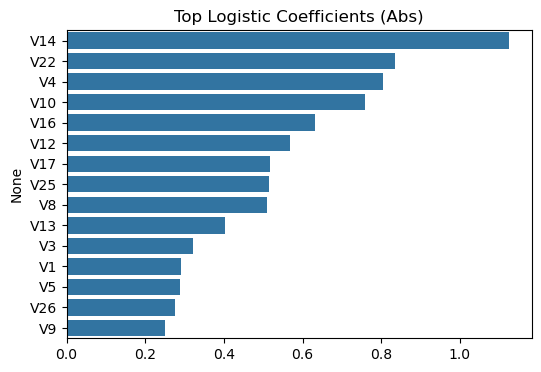

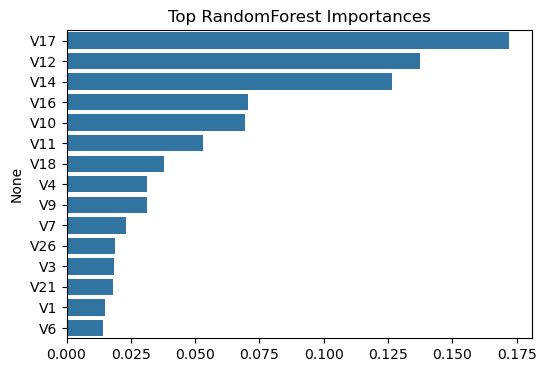

In [ ]:
# Feature importance / coefficients
coef_series = pd.Series(log_bal.coef_[0], index=X_train.columns).abs().sort_values(ascending=False).head(15)
plt.figure(figsize=(6,4))
sns.barplot(x=coef_series.values, y=coef_series.index)
plt.title('Top Logistic Coefficients (Abs)')
plt.show()
imp_series = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False).head(15)
plt.figure(figsize=(6,4))
sns.barplot(x=imp_series.values, y=imp_series.index)
plt.title('Top RandomForest Importances')
plt.show()

Features with largest absolute coefficients or Gini importance contribute most to discrimination
so V14 nu variance max hase

random forest etle j aatlu mast perform kare che as it gives importance to V14

In [ ]:
# Hypothesis testing (Mann-Whitney U) per feature
fraud = df[df['Class']==1]
non_fraud = df[df['Class']==0]
pvals = {}
feature_cols = [c for c in df.columns if c != 'Class']
for col in feature_cols:
    stat, p = mannwhitneyu(fraud[col], non_fraud[col], alternative='two-sided')
    pvals[col] = p
pval_df = pd.DataFrame({'feature': list(pvals.keys()), 'p_value': list(pvals.values())})
pval_df.sort_values('p_value', inplace=True)
display(pval_df.head())

# Multiple testing correction (FDR Benjamini-Hochberg)
rejected, qvals, _, _ = multipletests(pval_df['p_value'], alpha=0.05, method='fdr_bh')
pval_df['q_value'] = qvals
pval_df['rejected'] = rejected
significant = pval_df[pval_df['rejected']]
display(significant.head())
print(f'Significant features (q<0.05): {significant.shape[0]} of {len(feature_cols)}')

,feature,p_value
14,V14,1.471581e-260
4,V4,3.625904e-248
12,V12,8.416027e-247
11,V11,4.910592e-226
10,V10,9.611131e-222


,feature,p_value,q_value,rejected
14,V14,1.471581e-260,4.414742e-259,True
4,V4,3.625904e-248,5.438857e-247,True
12,V12,8.416027e-247,8.416027e-246,True
11,V11,4.910592e-226,3.682944e-225,True
10,V10,9.611131e-222,5.766679e-221,True


Significant features (q<0.05): 27 of 30


Mann-Whitney U identifies distributional shifts between fraud and non-fraud. FDR controls false discoveries across many tests, retained features show statistically significant difference.

In [19]:
# Retrain using selected (significant) features and compare
if 'significant' in globals():
    selected_features = significant['feature'].tolist()
    X_train_sel = X_train[selected_features]
    X_test_sel = X_test[selected_features]

    best_pipeline = ImbPipeline(steps=[('smote', SMOTE(random_state=RANDOM_STATE)),
                                       ('clf', LogisticRegression(max_iter=1000, random_state=RANDOM_STATE))])
    best_pipeline.fit(X_train_sel, y_train)
    sel_preds = best_pipeline.predict(X_test_sel)
    sel_proba = best_pipeline.predict_proba(X_test_sel)[:,1]
    reduced_metrics = {
        'model':'SMOTE_LogReg_Selected',
        'precision': precision_score(y_test, sel_preds, zero_division=0),
        'recall': recall_score(y_test, sel_preds, zero_division=0),
        'f1': f1_score(y_test, sel_preds, zero_division=0),
        'roc_auc': roc_auc_score(y_test, sel_proba),
        'pr_auc': average_precision_score(y_test, sel_proba)
    }
    print('Reduced feature metrics:')
    display(pd.DataFrame([reduced_metrics]))
else:
    print('Significant features not computed.')

Reduced feature metrics:


,model,precision,recall,f1,roc_auc,pr_auc
0,SMOTE_LogReg_Selected,0.132159,0.918367,0.231065,0.977758,0.728711


In [20]:
# Evaluate reduced vs full (SMOTE full already computed in smote_metrics)
comparison = []
if 'smote_metrics' in globals():
    comparison.append(smote_metrics)
if 'reduced_metrics' in globals():
    comparison.append(reduced_metrics)
if comparison:
    comp_df = pd.DataFrame(comparison)
    display(comp_df)

# Persist artifacts
if 'best_pipeline' in globals():
    joblib.dump(best_pipeline, 'final_smote_logreg_pipeline.joblib')
    if 'metrics_df' in globals():
        metrics_df.to_csv('all_model_metrics.csv', index=False)
    if 'selected_features' in globals():
        with open('selected_features.json','w') as f:
            json.dump(selected_features, f)
    print('Artifacts saved.')

,model,precision,recall,f1,roc_auc,pr_auc
0,LogReg_SMOTE,0.106538,0.897959,0.190476,0.975405,0.735695
1,SMOTE_LogReg_Selected,0.132159,0.918367,0.231065,0.977758,0.728711


Artifacts saved.


### Best Sampling Strategy
SMOTE and class_weight balanced logistic yields better recall/PR-AUC without discarding data. Under-sampling fastest but loses information.

### Metrics for Fraud Detection
Recall (catch fraud) and Precision (limit false alarms) balance via F1;, PR-AUC robust to imbalance, ROC-AUC appears deceptively high. 

### Hypothesis Testing Role
Non-parametric tests identify features with statistically different distributions, enabling dimensionality reduction before modeling, reducing noise and variance especially critical under severe imbalance.